In [118]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import plotly.express as px
import datetime
import plotly.graph_objects as go

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.tree import DecisionTreeRegressor

In [119]:
#today = datetime.datetime.now()

period1 = yf.download(
    tickers='BTC-USD',
    interval='1d',
    start='2020-03-02',
    end='2021-04-30',
)['Adj Close'].resample('7D').mean()

period2 = yf.download(
    tickers='BTC-USD',
    interval='1d',
    start='2021-11-01',
    end='2022-11-30',
)['Adj Close'].resample('7D').mean()

period1.reset_index(inplace=True)
period2.reset_index(inplace=True)

period1['Date'] = pd.to_datetime(period1['Date'])
period2['Date'] = pd.to_datetime(period2['Date'])

period1.describe()
period1.columns
period2.tail()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Ticker,Date,BTC-USD
52,2022-10-31,20672.421038
53,2022-11-07,17542.640485
54,2022-11-14,16651.560826
55,2022-11-21,16374.710798
56,2022-11-28,16331.152344


In [120]:
def plot_bitcoin_price(df, title, color='blue'):
    max_value = df['BTC-USD'].max()
    min_value = df['BTC-USD'].min()
    fig = px.line(df, 
                  x='Date', 
                  y='BTC-USD', 
                  title=title, 
                  color_discrete_sequence=[color])
    
    print(f"Min value: ${min_value:,.2f}")
    print(f"Max value: ${max_value:,.2f}")
    
    fig.show()

plot_bitcoin_price(period1, 'Bitcoin Price - 2020-03 to 2021-04')
plot_bitcoin_price(period2, 'Bitcoin Price - 2021-10 to 2022-10', "red")

Min value: $5,697.69
Max value: $61,184.77


Min value: $16,331.15
Max value: $65,510.88


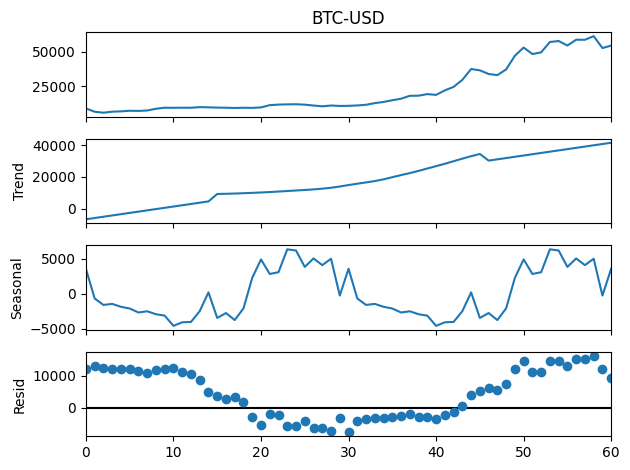

In [121]:
multi_dec = seasonal_decompose(period1['BTC-USD'], model='multiplicative', extrapolate_trend='freq', period=30)

aditive_dec = seasonal_decompose(period1['BTC-USD'], model='additive', extrapolate_trend='freq', period=30)

aditive_dec_plot = aditive_dec.plot()



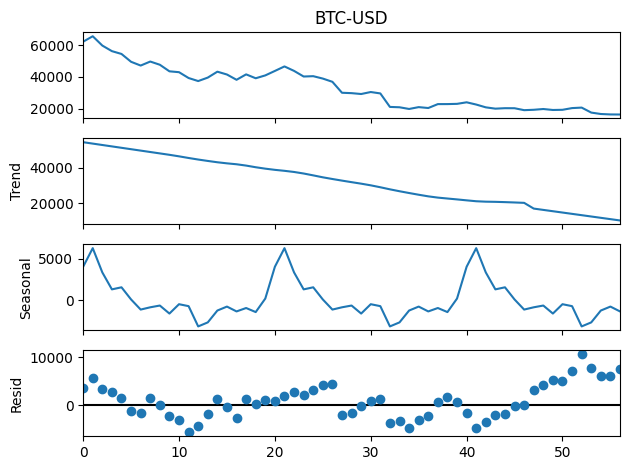

In [122]:
aditive_dec = seasonal_decompose(period2['BTC-USD'], model='additive', extrapolate_trend='freq', period=20)
aditive_dec_plot = aditive_dec.plot()

In [123]:
fed_p1 = pd.read_csv('FED/WM2NS-1p.csv') # second observation high the bitcoin price
fed_p2 = pd.read_csv('FED/WM2NS-2p.csv') # second observation declined the bitcoin price


fed_p1 = fed_p1.rename(columns={'observation_date': 'Date'})
fed_p2 = fed_p2.rename(columns={'observation_date': 'Date'})

fed_p1['Date'] = pd.to_datetime(fed_p1['Date'])
fed_p2['Date'] = pd.to_datetime(fed_p2['Date'])

type(fed_p1)
type(period1)

merged_p1_fed = pd.merge(period1, fed_p1, on='Date', how='inner')
merged_p2_fed = pd.merge(period2, fed_p2, on='Date', how='inner')

        Date      BTC-USD    WM2NS
0 2020-03-02  8804.583008  15510.5
1 2020-03-09  6410.282924  15646.2
2 2020-03-16  5697.691476  15839.8
3 2020-03-23  6454.665318  16210.2
4 2020-03-30  6665.847307  16629.2
Crescimento do Bitcoin e correlação com alta no W2: 
          BTC-USD     WM2NS
BTC-USD  1.000000  0.787016
WM2NS    0.787016  1.000000

Estabilidade de W2 e o Bitcoin: 
         BTC-USD    WM2NS
BTC-USD  1.00000  0.19329
WM2NS    0.19329  1.00000



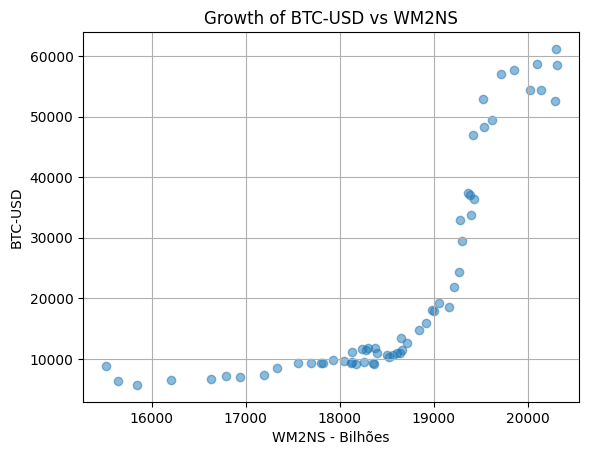

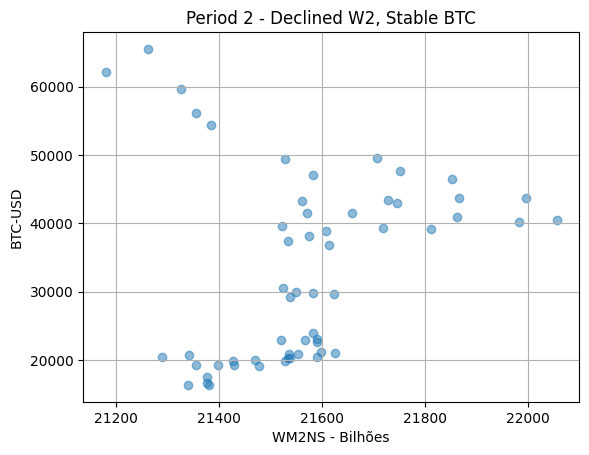

In [124]:
print(merged_p1_fed.head())

correlation_p1_fed = merged_p1_fed[['BTC-USD', 'WM2NS']].corr()
print(f"Crescimento do Bitcoin e correlação com alta no W2: \n{correlation_p1_fed}\n")

correlationn_p2_fed = merged_p2_fed[['BTC-USD', 'WM2NS']].corr()
print(f"Estabilidade de W2 e o Bitcoin: \n{correlationn_p2_fed}\n")

plt.scatter(merged_p1_fed['WM2NS'], merged_p1_fed['BTC-USD'], alpha=0.5)
plt.ylabel('BTC-USD')
plt.xlabel('WM2NS - Bilhões')
plt.title('Growth of BTC-USD vs WM2NS')
plt.grid(True)
plt.show()

plt.scatter(merged_p2_fed['WM2NS'], merged_p2_fed['BTC-USD'], alpha=0.5)
plt.ylabel('BTC-USD')
plt.xlabel('WM2NS - Bilhões')
plt.title('Period 2 - Declined W2, Stable BTC')
plt.grid(True)
plt.show()

In [125]:
irb_rate_p2 = pd.read_csv('IRRB/IORB-p2.csv')
irb_rate_p2 = irb_rate_p2.rename(columns={'observation_date': 'Date'})
irb_rate_p2['Date'] = pd.to_datetime(irb_rate_p2['Date'])

merged_p2_irb = pd.merge(period2, irb_rate_p2, on='Date', how='inner')

corr_irb_p2 = merged_p2_irb[['BTC-USD', 'IORB']].corr()

print(f"O aumento na taxa de juros, fará com que diminua o  preço do Bitcoin: \n{corr_irb_p2}\n")

# essa correlação é mais forte no segundo período
#o aumento da taxa de juros fará com que o preço sobre o bitcoin tenda a diminuir.

O aumento na taxa de juros, fará com que diminua o  preço do Bitcoin: 
          BTC-USD      IORB
BTC-USD  1.000000 -0.841936
IORB    -0.841936  1.000000



In [126]:
import statsmodels.api as sm

X = sm.add_constant(merged_p2_irb['IORB'])
y = merged_p2_irb['BTC-USD']

model = sm.OLS(y, X).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                BTC-USD   R-squared:                       0.709
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     133.9
Date:                Sun, 22 Dec 2024   Prob (F-statistic):           2.31e-16
Time:                        21:29:15   Log-Likelihood:                -586.95
No. Observations:                  57   AIC:                             1178.
Df Residuals:                      55   BIC:                             1182.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.465e+04   1394.671     32.014      0.0

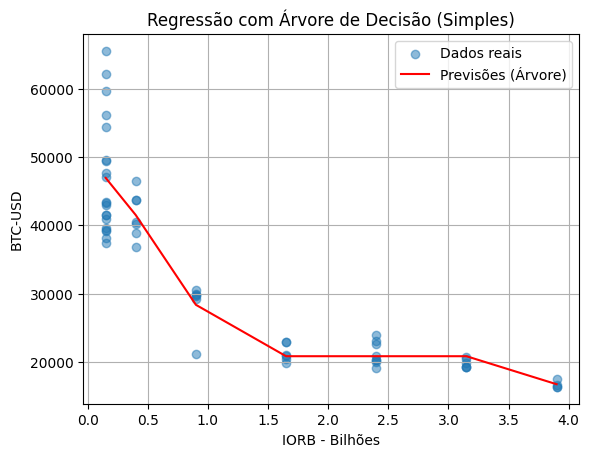

In [127]:
X = merged_p2_irb[['IORB']]
y = merged_p2_irb['BTC-USD']

arvore = DecisionTreeRegressor(max_depth=3)
arvore.fit(X, y)

predictions = arvore.predict(X)
plt.scatter(X, y, alpha=0.5, label='Dados reais')
plt.plot(X, predictions, color='red', label='Previsões (Árvore)')
plt.xlabel('IORB - Bilhões')
plt.ylabel('BTC-USD')
plt.title('Regressão com Árvore de Decisão (Simples)')
plt.legend()
plt.grid(True)
plt.show()